In [10]:
import os
import numpy as np
import nibabel as nib

from utils import calculate_dice_score
from em_algo import ExpectationMaximization

## Load Data

In [11]:
patient = 1

In [12]:
# Load the two NIfTI images
T1_path = f'data/{patient}/T1.nii'
T2_path = f'data/{patient}/T2_FLAIR.nii'
label_path = f'data/{patient}/LabelsForTesting.nii'
relative_save_path = f'results/singlemodal_s/{patient}/'


### Load the images from the path
T1 = nib.load(T1_path)
T1_np_img = T1.get_fdata()
T2 = nib.load(T2_path)
T2_np_img = T2.get_fdata()
labels = nib.load(label_path)
labels_np_img = labels.get_fdata()

In [13]:
# Perform Skull Stripping to get the brain mask for WM, GM, and CSF
## Isolate the brain voxels using the label
#### Get the indices of the brain voxels
brain_voxels_indices = np.where(labels_np_img > 0)
#### Get the brain voxels from the T1 image using the indices get from the label
T1_skull_stripped = T1_np_img[brain_voxels_indices]

### Stack the T1 and T2 images to get the multi-modal image
X = np.expand_dims(T1_skull_stripped, axis=1)

## EM Algorithm

In [14]:
## Min Max scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
# scaler = StandardScaler()

X = scaler.fit_transform(X)

Iteration:  0  --- Log Likelihood:  13.499774348548794  --- Time (s):  0.04570484161376953


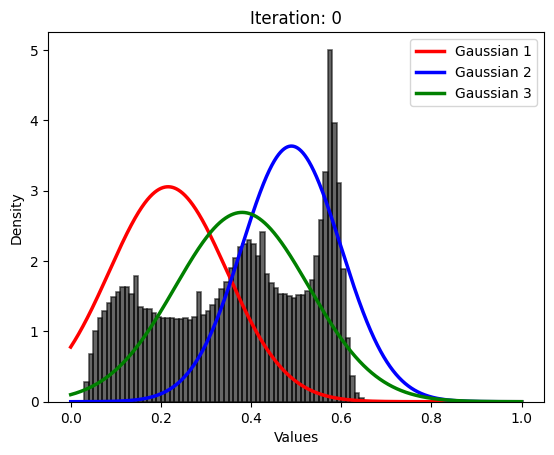

Iteration:  1  --- Log Likelihood:  13.510321879684646  --- Time (s):  0.04949188232421875
Iteration:  2  --- Log Likelihood:  13.518287550362272  --- Time (s):  0.0562441349029541
Iteration:  3  --- Log Likelihood:  13.524742171593335  --- Time (s):  0.08198690414428711
Iteration:  4  --- Log Likelihood:  13.529905344735038  --- Time (s):  0.06068992614746094
Iteration:  5  --- Log Likelihood:  13.534121584170803  --- Time (s):  0.0415797233581543
Iteration:  6  --- Log Likelihood:  13.53791180480242  --- Time (s):  0.03913402557373047
Iteration:  7  --- Log Likelihood:  13.54179935136072  --- Time (s):  0.03886985778808594
Iteration:  8  --- Log Likelihood:  13.54629595042154  --- Time (s):  0.04691004753112793
Iteration:  9  --- Log Likelihood:  13.551966415688  --- Time (s):  0.04575705528259277
Iteration:  10  --- Log Likelihood:  13.559486611259834  --- Time (s):  0.045864105224609375
Iteration:  11  --- Log Likelihood:  13.569620641456446  --- Time (s):  0.0393221378326416
Itera

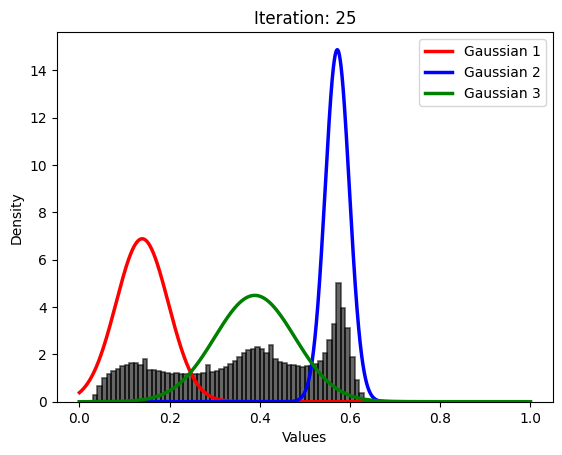

Iteration:  26  --- Log Likelihood:  13.693734204615897  --- Time (s):  0.04245400428771973
Iteration:  27  --- Log Likelihood:  13.694802738158788  --- Time (s):  0.04211115837097168
Iteration:  28  --- Log Likelihood:  13.695632083377399  --- Time (s):  0.0805356502532959
Iteration:  29  --- Log Likelihood:  13.696274856578947  --- Time (s):  0.04975605010986328
Iteration:  30  --- Log Likelihood:  13.696773029415226  --- Time (s):  0.0375370979309082
Iteration:  31  --- Log Likelihood:  13.697159582313887  --- Time (s):  0.04087424278259277
Iteration:  32  --- Log Likelihood:  13.697460135849823  --- Time (s):  0.03795766830444336
Iteration:  33  --- Log Likelihood:  13.697694429560114  --- Time (s):  0.039166927337646484
Iteration:  34  --- Log Likelihood:  13.697877589227616  --- Time (s):  0.0360410213470459
Iteration:  35  --- Log Likelihood:  13.69802117070818  --- Time (s):  0.04216504096984863
Iteration:  36  --- Log Likelihood:  13.698133995227733  --- Time (s):  0.039949655

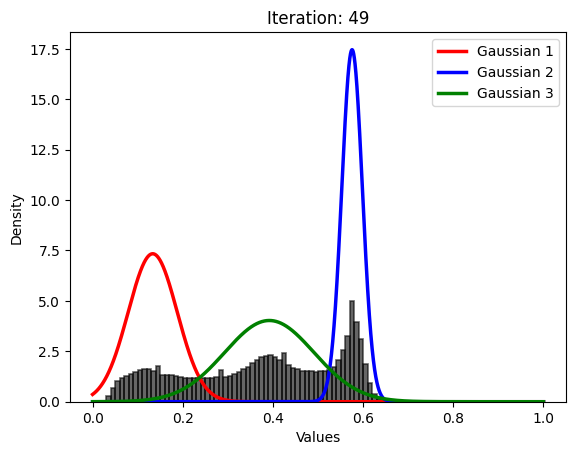

In [15]:
# Initialize the Expectation Maximization algorithm
em = ExpectationMaximization(X, k=3, max_iter=50, type='kmeans', plot_step=25, save_path=relative_save_path, show_plot=True, stop_criterion=1e-6)
alphas, mus, covars, W = em.fit()

## Postprocessing

Sort the means of the Gaussian components. This helps us map the classes to the intensity ranges.  
	•	The smallest mean will be assigned to CSF (1).  
	•	The middle mean will be assigned to GM (2).  
	•	The largest mean will be assigned to WM (3).  

In [16]:
# Assign each voxel to the cluster with the highest probability
voxel_assignments = np.argmax(W, axis=1)  # Get the index of the highest responsibility for each voxel
# Create a new 3D image with the same shape as the original brain image
segmented_image = np.zeros_like(T1_np_img)
# Map the voxel assignments back to the 3D segmented image using the brain_voxels_indices
segmented_image[brain_voxels_indices] = voxel_assignments + 1  # +1 to make the clusters 1, 2, 3

In [17]:
## 1 - CSF, 2 - GM, 3 - WM 
## Sort the clusters based on the mean intensity of the voxels in each cluster
sorted_mean_indices = np.argsort(np.mean(mus, axis=1)) + 1
## Assign the clusters to the correct class
class1_idx = np.where(segmented_image == sorted_mean_indices[0])
class2_idx = np.where(segmented_image == sorted_mean_indices[1])
class3_idx = np.where(segmented_image == sorted_mean_indices[2])
segmented_image[class1_idx] = 1
segmented_image[class2_idx] = 2
segmented_image[class3_idx] = 3

# Save the segmented image
segmented_img_nifti = nib.Nifti1Image(segmented_image, T1.affine)
nib.save(segmented_img_nifti, os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))

print("Segmented brain image saved as " + os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))

Segmented brain image saved as results/singlemodal_s/1/segmented_brain_1.nii


## Evaluation

In [18]:
# Calculate the Dice score between the predicted labels and the ground truth
dice_scores = calculate_dice_score(label_path, os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))    
print(dice_scores)
print('Average Dice Score: ', np.mean(list(dice_scores.values())))

{1: 0.793930868021098, 2: 0.7773567300223594, 3: 0.8573641299722558}
Average Dice Score:  0.8095505760052376


## Visualization

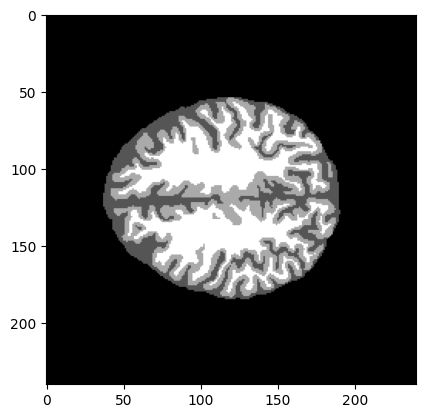

In [19]:
import matplotlib.pyplot as plt
plt.imshow(labels_np_img[:,:, 30], cmap='gray')
plt.show()

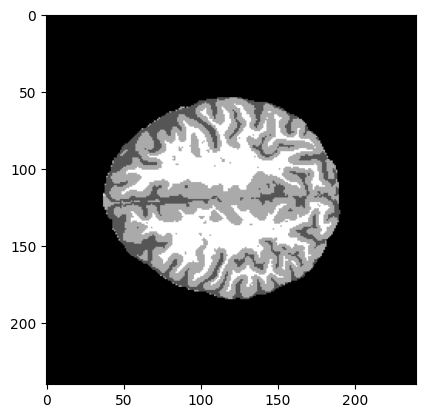

In [20]:
import matplotlib.pyplot as plt
plt.imshow(segmented_image[:,:, 30], cmap='gray')
plt.show()